# Image Processing with MRI_images

- toc: true
- caregories: [image-processing]

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pydicom
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
from scipy import ndimage as nd # contains gaussian filter

## Denoising filters

### Gaussian filter

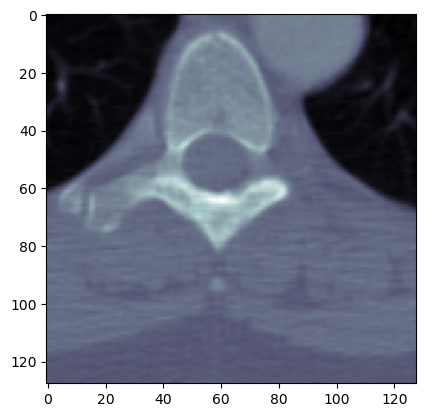

In [2]:
# dicom file has a lot of information so we just need to extract the pixel array because it will define the image

dataset = pydicom.dcmread("/media/siddy/D Drive/Image Processing/images/MRI_images/CT_small.dcm")
img = dataset.pixel_array
plt.imshow(img, cmap=plt.cm.bone)
plt.show()

In [3]:
# how to save dcm image to tif ??
#plt.imsave("/media/siddy/D Drive/Image Processing/images/MRI_images/dcm_to_tiff.tif", img, cmap='gray')

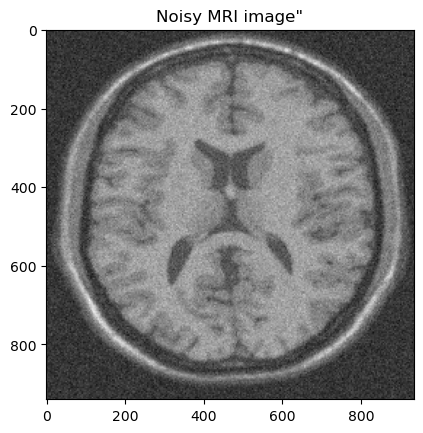

In [4]:
noisy_img  = img_as_float(io.imread("/media/siddy/D Drive/Image Processing/images/MRI_images/MRI_noisy.tif"))
plt.imshow(noisy_img, cmap = 'gray')
plt.title('Noisy MRI image"')
plt.show()

In [5]:
clean_img = img_as_float(io.imread("/media/siddy/D Drive/Image Processing/images/MRI_images/MRI_clean.tif"))

In [6]:
print(noisy_img.shape, clean_img.shape)

(940, 934) (940, 934)


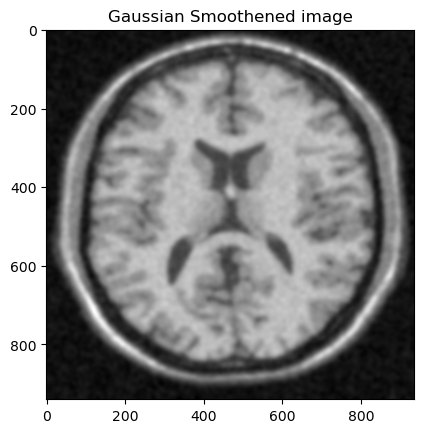

In [7]:
# Applying Gaussian Filter

gaussian_img = nd.gaussian_filter(noisy_img, sigma=5) # heigher the sigma better the denoising, image gets blurry 
plt.imshow(gaussian_img, cmap='gray')
plt.title('Gaussian Smoothened image')
plt.show()

In [8]:
#plt.imsave("images/MRI_images/Gaussian_smoothed.tiff", gaussian_img, cmap='gray')


Peak Signal to Noise Ratio

In [9]:
noise_psnr = peak_signal_noise_ratio(clean_img, noisy_img)
gaussian_psnr = peak_signal_noise_ratio(clean_img, gaussian_img)
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of gaussian cleaned image =", gaussian_psnr)

PSNR of input noisy image =  17.03789982624248
PSNR of gaussian cleaned image = 17.112001291081445


### Bilateral, TV(Total Variation) and Wavelet

In [10]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import img_as_float


In [11]:
sigma_est = estimate_sigma(noisy_img, multichannel=True, average_sigmas=True)
print(sigma_est)

0.011082816474057382


PSNR of bilateral cleaned image =  16.225197089561874


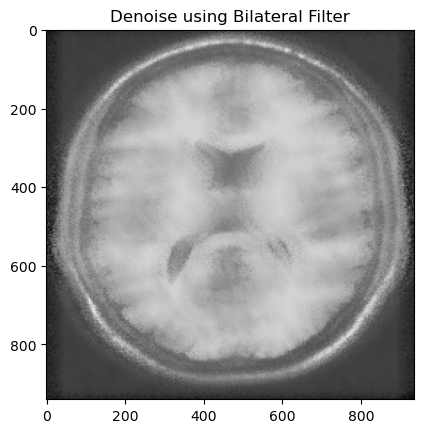

In [12]:
# Denoise Bilateral

denoise_bilateral = denoise_bilateral(noisy_img, sigma_spatial=15, multichannel=False) # sigma_spatial controls the amount of denoising 
bilateral_psnr = peak_signal_noise_ratio(clean_img, denoise_bilateral)
print("PSNR of bilateral cleaned image = ", bilateral_psnr)
plt.imshow(denoise_bilateral, cmap='gray')
plt.title("Denoise using Bilateral Filter")
plt.show()

PSNR of TV_cleaned image =  17.19161931394431


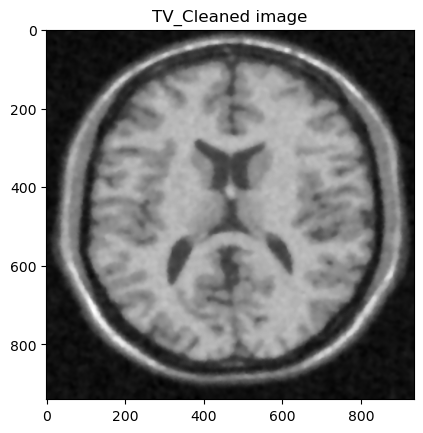

In [13]:
# TV --> best one i got

denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.3, multichannel=False)
TV_cleaned_psnr = peak_signal_noise_ratio(clean_img, denoise_TV)
print("PSNR of TV_cleaned image = ", TV_cleaned_psnr)
plt.imshow(denoise_TV, cmap='gray')
plt.title("TV_Cleaned image")
plt.show()

PSNR of wavelet_cleaned image=  17.0525032515753


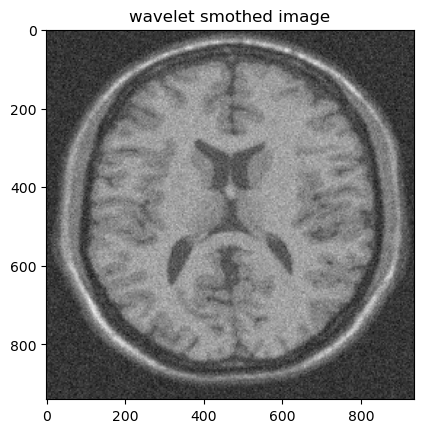

In [14]:
#Wavelet

wavelet_smoothed = denoise_wavelet(noisy_img, multichannel= False, method='BayesShrink', mode='soft', rescale_sigma=True)
wavelet_cleaned_psnr = peak_signal_noise_ratio(clean_img, wavelet_smoothed)
print("PSNR of wavelet_cleaned image= ", wavelet_cleaned_psnr)
plt.imshow(wavelet_smoothed, cmap='gray')
plt.title("wavelet smothed image")
plt.show()

Shift invariant wavelet denoising
https://scikit-image.org/docs/dev/auto_examples/filters/plot_cycle_spinning.html

### Anisotropic Diffusion

In [15]:
import cv2
from medpy.filter.smoothing import anisotropic_diffusion
# niter= number of iterations
#kappa = Conduction coefficient (20 to 100)
#gamma = speed of diffusion (<=0.25)
#Option: Perona Malik equation 1 or 2. A value of 3 is for Turkey's biweight function 

In [16]:
noisy_img  = img_as_float(io.imread("/media/siddy/D Drive/Image Processing/images/MRI_images/MRI_noisy.tif", as_gray=True))


In [17]:
img_aniso_filtered = anisotropic_diffusion(noisy_img, niter=50, kappa= 50, gamma=0.2, option=2)

/home/siddy/anaconda3/envs/torch/lib/python3.8/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/siddy/anaconda3/envs/torch/lib/python3.8/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [18]:
anisotropic_cleaned_psnr = peak_signal_noise_ratio(clean_img, img_aniso_filtered)
print("PSNR of input noisy image = ", noise_psnr)

PSNR of input noisy image =  17.03789982624248


<ipython-input-18-f16d8ead5ed0>:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  anisotropic_cleaned_psnr = peak_signal_noise_ratio(clean_img, img_aniso_filtered)


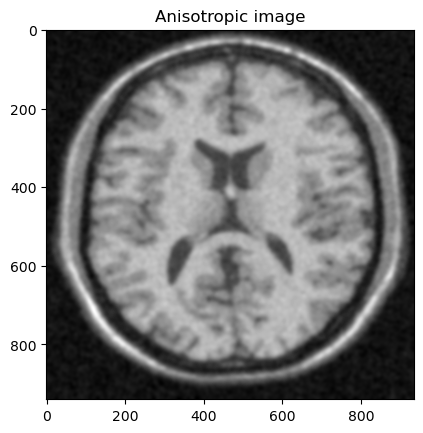

In [19]:
plt.imshow(img_aniso_filtered, cmap='gray')
plt.title("Anisotropic image")
plt.show()

### Non-Local Means (NLM)

In [20]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
import numpy as np

In [21]:
sigma_est = np.mean(estimate_sigma(noisy_img, multichannel=False))

In [22]:
NLM_skimg_denoise_img = denoise_nl_means(noisy_img, h=1.15*sigma_est, fast_mode=True, patch_size=0, patch_distance=5, multichannel=False)

In [23]:
NLM_skimg_cleaned_psnr = peak_signal_noise_ratio(clean_img, NLM_skimg_denoise_img)
print("PSNR of input noisy image =", NLM_skimg_cleaned_psnr)

PSNR of input noisy image = 17.261562408895422


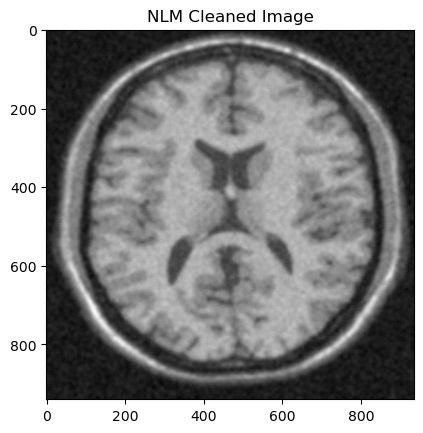

In [24]:
plt.imshow(NLM_skimg_denoise_img, cmap='gray')
plt.title('NLM Cleaned Image')
plt.show()

```python
fastNlMeansDenoising(InputArray src, OutputArray dst, float h=3, int templateWindowSize=7, intsearchWindowSize=21)

NLM_CV2_denoise_img = cv2.fastNlMeansDenoising(noisy_img, None, 3, 7, 21)

plt.imshow("images/MRI_images/NLM_CV2_denoised.tif", NLM_CV2_denoise_img, cmap='gray')
plt.show()
```

### BM3D Block-matching and 3D filtering

In [25]:
import bm3d

In [27]:
noisy_img = img_as_float(io.imread("/media/siddy/D Drive/Image Processing/images/MRI_images/MRI_noisy.tif", as_gray=True))


```python
BM3D_denoised_image = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

#BM3D_denoised_image = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

#try stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING                     


BM3D_cleaned_psnr = peak_signal_noise_ratio(clean_img, BM3D_denoised_image)

print("PSNR of cleaned image = ", BM3D_cleaned_psnr)

plt.imshow(BM3D_denoised_image, cmap='gray')
plt.title('BMED Cleaned image')
plt.show()
```

### MRF

Code from following github. It works but too slow and not as good as the above filters. 
https://github.com/ychemli/Image-denoising-with-MRF/blob/master/ICM_denoising.py
Very slow... and not so great
http://www.cs.toronto.edu/~fleet/courses/2503/fall11/Handouts/mrf.pdf
```python
import cv2


potential fonction corresponding to a gaussian markovian model (quadratic function)
def pot(fi, fj):
    return float((fi-fj))**2
	
#ICM : Iterated conditional mode algorithme
def ICM(img, iter, beta):
    NoisyIm = cv2.imread(img, 0)
    height, width = NoisyIm.shape

    sigma2 = 5
beta is the regularization parameter 

     iter is the Number of iterations : each new image is used as the new restored image
    for iter in range(iter):
        print("iteration {}\n".format(iter+1))
        for i in range(height-1):
            print("line {}/{} ok\n".format(i+1, height))
            for j in range(width-1):
		 We work in 4-connexity here
                xmin = 0
                min = float((NoisyIm[i][j]*NoisyIm[i][j]))/(2.0*sigma2) + beta*(pot(NoisyIm[i][j-1],0)+pot(NoisyIm[i][j+1],0)+pot(NoisyIm[i-1][j], 0)+pot(NoisyIm[i+1][j], 0))

		Every shade of gray is tested to find the a local minimum of the energie corresponding to a Gibbs distribution
                for x in range(256):
                    proba = float(((NoisyIm[i][j]-x)*(NoisyIm[i][j]-x)))/(2.0*sigma2) + beta*(pot(NoisyIm[i][j-1],x) + pot(NoisyIm[i][j+1],x) + pot(NoisyIm[i-1][j], x) + pot(NoisyIm[i+1][j], x))

                    if(min>proba):
                        min = proba
                        xmin = x
                NoisyIm [i][j] = xmin

        cv2.imwrite("iter_" + str(iter+1) + "_denoised_" + img, NoisyIm)


if __name__ == '__main__':
    ICM('/media/siddy/D Drive/Image Processing/images/MRI_images/BM3D_denoised.tif', 10, 1)

```